In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [12]:
data=pd.read_csv('Data.csv')

In [13]:
data.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [14]:
def split_genres(genre_string):
    return genre_string.split('|')

data['genre_list'] = data['genres'].apply(split_genres)
data['genresProcessed'] = data['genre_list'].apply(lambda x: ', '.join(x))

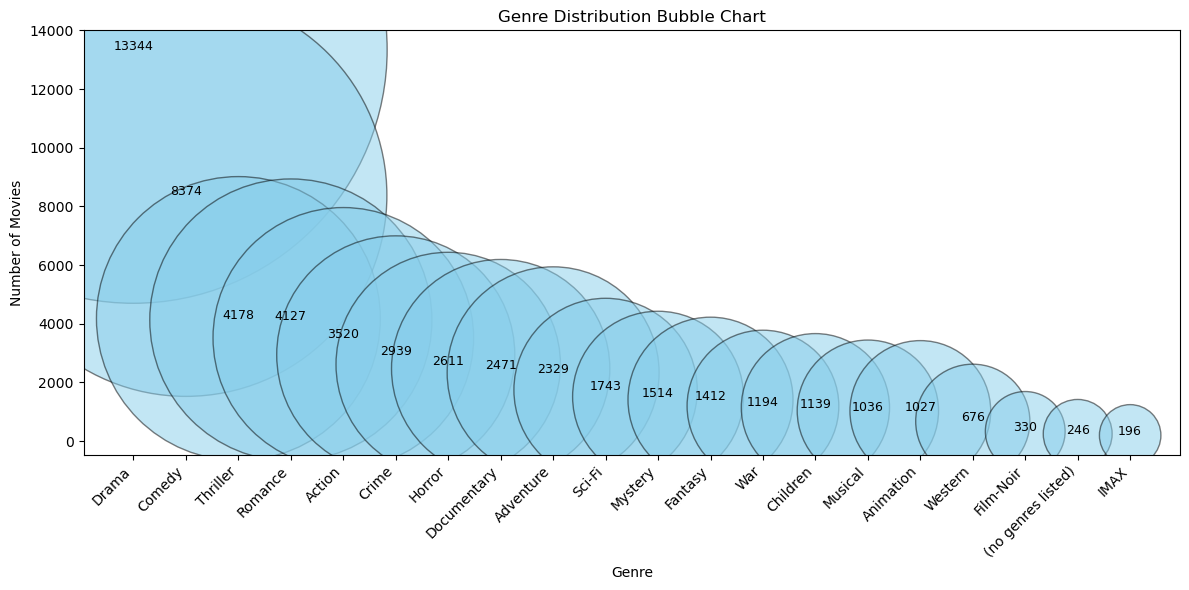

In [15]:
exploded_genres = data.explode('genre_list')
genre_counts = exploded_genres['genre_list'].value_counts().reset_index()
genre_counts.columns = ['Genre', 'Number of Movies']

# Bubble chart
plt.figure(figsize=(12, 6))
plt.scatter(genre_counts['Genre'], genre_counts['Number of Movies'], s=genre_counts['Number of Movies']*10, alpha=0.5, c='skyblue', edgecolor='black')
for i, row in genre_counts.iterrows():
    plt.text(row['Genre'], row['Number of Movies'], f'{row["Number of Movies"]}', fontsize=9, ha='center')

plt.title('Genre Distribution Bubble Chart')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

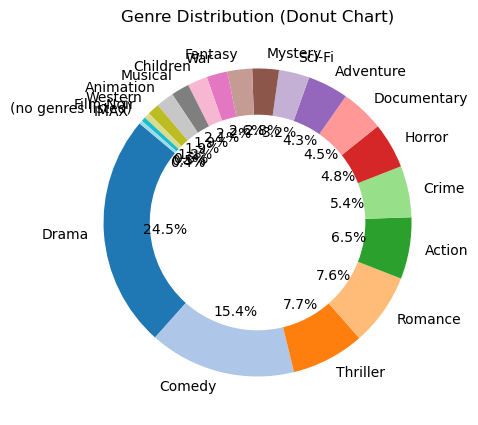

In [16]:
exploded_genres = data.explode('genre_list')
genre_counts = exploded_genres['genre_list'].value_counts()

# Donut chart
plt.figure(figsize=(6,5))
plt.pie(genre_counts, labels=genre_counts.index, autopct='%1.1f%%', colors=plt.get_cmap('tab20').colors, startangle=140, wedgeprops=dict(width=0.3))
plt.title('Genre Distribution (Donut Chart)')
plt.show()

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer


tf = TfidfVectorizer(analyzer='word', ngram_range=(1,2))
tfidf_matrix = tf.fit_transform(data['genresProcessed'])

### Cosine Similarity:

In [18]:
from sklearn.metrics.pairwise import cosine_similarity


cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim_df = pd.DataFrame(cosine_sim, index=data['title'], columns=data['title'])
def get_recommendations_cosine(movie_title, similarity_df, movies_df, k=10):
    ix = similarity_df.loc[:, movie_title].to_numpy().argpartition(range(-1, -k, -1))
    closest = similarity_df.columns[ix[-1:-(k + 2):-1]]
    closest = closest.drop(movie_title, errors='ignore')
    recommendations = pd.DataFrame(closest, columns=['title']).merge(movies_df[['title', 'genresProcessed']], on='title')
    print(recommendations.head(k))
    return recommendations


### KNN with Cosine Similarity:

In [21]:
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import KFold

knn = NearestNeighbors(n_neighbors=10, metric='cosine')
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Function to compute average similarity for evaluation
def evaluate_knn(tfidf_matrix, knn, cv):
    scores = []
    for train_index, test_index in cv.split(tfidf_matrix):
        X_train, X_test = tfidf_matrix[train_index], tfidf_matrix[test_index]
        knn.fit(X_train)
        distances, indices = knn.kneighbors(X_test)
        # Convert distances to similarity
        similarities = 1 - distances
        avg_similarity = np.mean(similarities)
        scores.append(avg_similarity)
    return scores

cv_scores = evaluate_knn(tfidf_matrix, knn, cv)
average_cv_score = np.mean(cv_scores)
print(f'Average Cross-Validation Similarity Score: {average_cv_score:.4f}')
print(f'Number of Cross-Validation Folds: {cv.n_splits}')
print(f'Cross-Validation Scores: {cv_scores}')


knn.fit(tfidf_matrix)

# k-NN Function
def get_recommendations_knn(movie_title, tfidf_matrix, movies_df, knn, k=10):
    if movie_title not in movies_df['title'].values:
        print(f"Movie '{movie_title}' not found in the dataset.")
        return pd.DataFrame()  # Return an empty DataFrame
    
    movie_idx = movies_df[movies_df['title'] == movie_title].index[0]
    movie_vector = tfidf_matrix[movie_idx]
    distances, indices = knn.kneighbors(movie_vector, n_neighbors=k + 1)
    closest_indices = indices.flatten()
    closest_indices = closest_indices[closest_indices != movie_idx]
    
    # Select only the relevant columns and reset index
    closest_movies = movies_df.iloc[closest_indices][['title', 'genresProcessed']]
    closest_movies.reset_index(drop=True, inplace=True)  # Reset index to 0, 1, 2, ...
    
    print(closest_movies.head(k))
    return closest_movies


Average Cross-Validation Similarity Score: 0.9855
Number of Cross-Validation Folds: 5
Cross-Validation Scores: [0.9868049903870225, 0.985661206174094, 0.9841081618510239, 0.9850104061779387, 0.98615129551355]


In [22]:
x = 'Cutthroat Island (1995)'
print("Cosine Similarity Recommendations:")
y_cosine = get_recommendations_cosine(x, cosine_sim_df, data[['title', 'genresProcessed']])
print("\nk-NN Recommendations:")
y_knn = get_recommendations_knn(x, tfidf_matrix, data[['title', 'genresProcessed']], knn)


Cosine Similarity Recommendations:
                                  title             genresProcessed
0  Adventures of Robin Hood, The (1938)  Action, Adventure, Romance
1                  Captain Blood (1935)  Action, Adventure, Romance
2  Adventures of Hajji Baba, The (1954)  Action, Adventure, Romance
3          Three Musketeers, The (1921)  Action, Adventure, Romance
4         Prisoner of Zenda, The (1937)  Action, Adventure, Romance
5                  Sea Hawk, The (1940)  Action, Adventure, Romance
6       Flame and the Arrow, The (1950)  Action, Adventure, Romance
7                      Host, The (2013)  Action, Adventure, Romance
8           King Solomon's Mines (1950)  Action, Adventure, Romance
9         Adventures of Don Juan (1948)          Adventure, Romance

k-NN Recommendations:
                                  title             genresProcessed
0                  Captain Blood (1935)  Action, Adventure, Romance
1  Adventures of Robin Hood, The (1938)  Action, Adventure

### Conclusion:

The genre distribution analysis highlighted the prevalence of various genres in the dataset, presented through a bubble chart and a donut chart. Both cosine similarity and k-NN recommendation systems were implemented and evaluated. The k-NN model demonstrated its effectiveness with a notable average cross-validation similarity score, confirming its capability in providing relevant movie recommendations.

